# Packages Installs, imports, and presets

In [1]:
#from scapy.all import *
import pandas as pd
#import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import defaultdict
import os
from transformers import MobileViTV2Model, MobileViTV2Config
import torch
import torchmetrics
from torch import optim
import lightning as L
import torch
import torch.nn as nn
from lightning.pytorch.callbacks import LearningRateMonitor
import utils

In [2]:
from lightning.pytorch.loggers import WandbLogger
import wandb


In [3]:
INPUT_SIZE = (256,256,3)

In [4]:
NO_PAYLOAD = False

# Feature engineering and Loading

In [5]:
TIMEOUT = 30

In [6]:
df_train= pd.read_parquet(f'data/iec104_train_{TIMEOUT}.parquet')
df_validation = pd.read_parquet(f'data/iec104_validation_{TIMEOUT}.parquet')
df_test=pd.read_parquet(f'data/iec104_test_{TIMEOUT}.parquet')

In [7]:

print('train, validation,test (shape):',df_train.shape,df_validation.shape,df_test.shape)
print('train, validation,test (number of flows):',df_train.index.nunique(),df_validation.index.nunique(),df_test.index.nunique())

train, validation,test (shape): (383703, 30) (32635, 30) (108734, 30)
train, validation,test (number of flows): 9757 1085 2711


packet_number
2         6
3         1
4         1
5         1
6        36
7      2233
8      4325
9      1960
10      435
11      329
12      236
13       62
14       12
15        4
16        4
17        2
19        2
22        4
23        2
25        1
26        3
27        2
30        1
60        1
67        1
73        2
75        1
79        1
88        1
91        1
93        1
96        1
99        1
133       1
136       1
138       1
141       3
142       2
147       1
196       1
206       2
207       1
222       1
226       1
237       1
264       1
280       1
281       1
293       1
549       1
Name: count, dtype: int64


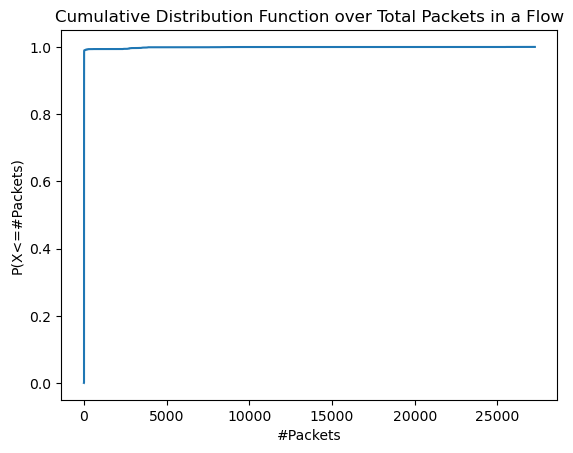

In [8]:
tmp=df_train.groupby('flow')['packet_number'].count().value_counts()
tmp = tmp.sort_index()
print(tmp.head(50))
tmp = tmp.cumsum()
tmp = tmp/tmp.max()
plt.title('Cumulative Distribution Function over Total Packets in a Flow')
plt.xlabel("#Packets")
plt.ylabel(r"P(X<=#Packets)")
plt.plot(tmp)

In [9]:

utils.encode_time(df_train)
utils.encode_time(df_validation)
utils.encode_time(df_test)

In [10]:
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder
# od = OrdinalEncoder(encoding_method='arbitrary')
od = OneHotEncoder(ignore_format=True)
feats=['ip_src','ip_dst','tcp_options','tcp_dataofs','ip_ttl']

# df_train= pd.get_dummies(df_train,columns=feats)
# df_validation= pd.get_dummies(df_validation,columns=feats)
# df_test= pd.get_dummies(df_test,columns=feats)
od.fit(df_train[feats])
# display(df_train[feats])
def one_hot_encode_feats(df_train,feats):
    
    df_train = pd.concat([df_train,od.transform(df_train[feats])],axis=1)
    df_train=df_train.drop(feats,axis=1)
    return df_train
df_train = one_hot_encode_feats(df_train,feats)
df_test = one_hot_encode_feats(df_test,feats)
df_validation = one_hot_encode_feats(df_validation,feats)

In [11]:
# od.transform(df_train[feats])



In [12]:
# def tcp_ports_str(df):
#     df['tcp_dport']=df['tcp_sport'].astype(str)
#     df['tcp_dport']=df['tcp_dport'].astype(str)
# tcp_ports_str(df_train)
# tcp_ports_str(df_validation)
# tcp_ports_str(df_test)

In [13]:
# df_train['tcp_sport']


# df_train = int_to_binary(df_train,'tcp_dport')
# df_train = int_to_binary(df_train,'tcp_sport')
# df_validation = int_to_binary(df_validation,'tcp_dport')
# df_validation = int_to_binary(df_validation,'tcp_sport')
# df_test = int_to_binary(df_test,'tcp_dport')
# df_test = int_to_binary(df_test,'tcp_sport')

In [14]:
# from feature_engine.encoding import OneHotEncoder
# od = OneHotEncoder()

# feats=['ip_src','ip_dst']
# display(df_train[feats].nunique())
# od.fit(df_train[feats])
# df_train[feats] = od.transform(df_train[feats])
# df_validation[feats] = od.transform(df_validation[feats])
# df_test[feats] = od.transform(df_test[feats])
# for feat in feats:
#     od.fit(df_train[feat])
#     df_train[feat] = od.transform(df_train[feat])
#     df_validation[feat] = od.transform(df_validation[feat])
#     df_test[feat] = od.transform(df_test[feat])

In [15]:
cols_to_drop = list(df_train.columns[df_train.nunique() == 1]) + ['tcp_dport','tcp_sport']
print(cols_to_drop)
# Drop these columns from the DataFrame
df_train = df_train.drop(cols_to_drop, axis=1)
df_validation = df_validation.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)

['ip_version', 'ip_ihl', 'ip_tos', 'ip_flags', 'ip_frag', 'ip_proto', 'ip_options', 'tcp_reserved', 'tcp_flags', 'tcp_urgptr', 'tcp_dport', 'tcp_sport']


In [16]:
df_train.columns

Index(['packet_number', 'ip_len', 'ip_id', 'ip_chksum', 'tcp_seq', 'tcp_ack',
       'tcp_window', 'tcp_chksum', 'size', 'payload', 'payload_raw', 'label',
       'hour', 'minute', 'second', 'hour_sin', 'hour_cos', 'minute_sin',
       'minute_cos', 'second_sin', 'second_cos', 'ip_src_192.168.1.29',
       'ip_src_192.168.1.19', 'ip_src_192.168.1.27', 'ip_src_192.168.1.25',
       'ip_src_192.168.1.26', 'ip_src_192.168.1.28', 'ip_src_192.168.1.24',
       'ip_src_192.168.1.13', 'ip_src_192.168.1.21', 'ip_src_192.168.1.22',
       'ip_src_192.168.1.20', 'ip_dst_192.168.1.19', 'ip_dst_192.168.1.29',
       'ip_dst_192.168.1.25', 'ip_dst_192.168.1.27', 'ip_dst_192.168.1.26',
       'ip_dst_192.168.1.24', 'ip_dst_192.168.1.28', 'ip_dst_192.168.1.13',
       'ip_dst_192.168.1.21', 'ip_dst_192.168.1.22', 'ip_dst_192.168.1.20',
       'tcp_options_3', 'tcp_options_0', 'tcp_dataofs_8', 'tcp_dataofs_5',
       'ip_ttl_64', 'ip_ttl_128'],
      dtype='object')

In [17]:
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import MinMaxScaler,StandardScaler
numeric_features = [
    'ip_len', 'ip_id',  'ip_chksum',  'tcp_seq', 'tcp_ack',
     'tcp_window', 'tcp_chksum', 'size'
]
# numeric_features = [
#     'tcp_seq', 'tcp_ack'
# ]



# Initialize MinMaxScaler
scaler = SklearnTransformerWrapper(StandardScaler())
scaler.fit(df_train[numeric_features])
# Fit and transform the DataFrame
df_train[numeric_features] = scaler.transform(df_train[numeric_features])
df_test[numeric_features] = scaler.transform(df_test[numeric_features])
df_validation[numeric_features] = scaler.transform(df_validation[numeric_features])

In [18]:
df_train.shape

(383703, 49)

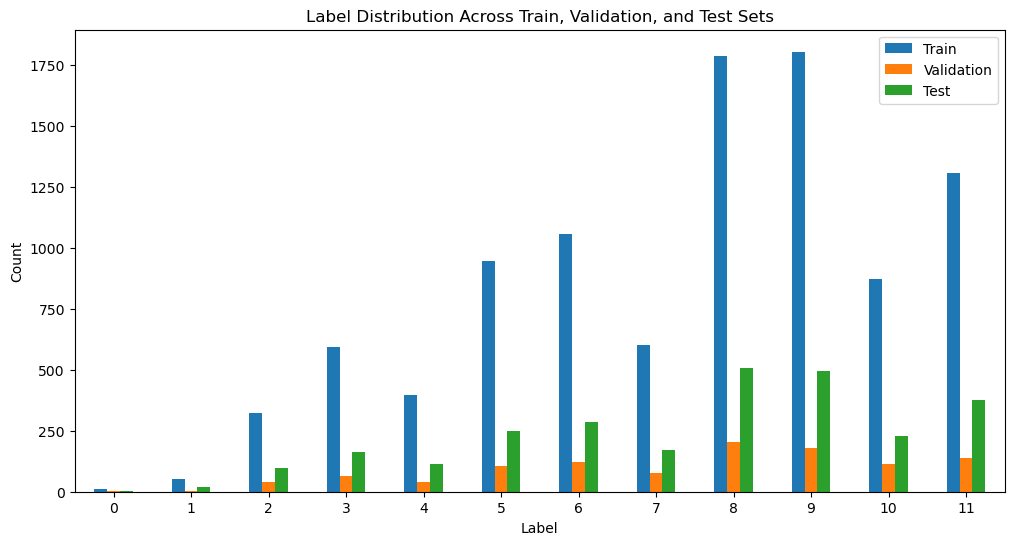

In [19]:
train_counts= df_train.reset_index().drop_duplicates('flow')['label'].value_counts().sort_index()
plt.show()
validation_counts= df_validation.reset_index().drop_duplicates('flow')['label'].value_counts().sort_index()
plt.show()
test_counts=df_test.reset_index().drop_duplicates('flow')['label'].value_counts().sort_index()
plt.show()

df_combined = pd.DataFrame({
    'Train': train_counts,
    'Validation': validation_counts,
    'Test': test_counts
})
ax = df_combined.plot(kind='bar', figsize=(12, 6))
ax.set_title('Label Distribution Across Train, Validation, and Test Sets')
ax.set_xlabel('Label')
ax.set_ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [20]:
df_train.head(1000).to_csv('views/fids_train_dummy.csv')

In [21]:
tmp=df_train.groupby('flow')['ip_id'].count().value_counts()
tmp=tmp.sort_index().cumsum()
tmp = tmp/tmp.max()
display(tmp)

ip_id
2        0.000615
3        0.000717
4        0.000820
5        0.000922
6        0.004612
           ...   
8808     0.999590
9579     0.999693
25497    0.999795
25537    0.999898
27265    1.000000
Name: count, Length: 111, dtype: float64

In [22]:
MAX_PAYLOAD_LENGTH = df_train['payload_raw'].apply(len).max()
# Transform the DataFrame

if NO_PAYLOAD:
    df_train.drop('payload_raw',axis=1,inplace=True)
    df_test.drop('payload_raw',axis=1,inplace=True)
    df_validation.drop('payload_raw',axis=1,inplace=True)
else:
    df_train=utils.payload_to_binary_columns(df_train, 'payload_raw',MAX_PAYLOAD_LENGTH)
    df_validation=utils.payload_to_binary_columns(df_validation, 'payload_raw',MAX_PAYLOAD_LENGTH)
    df_test=utils.payload_to_binary_columns(df_test, 'payload_raw',MAX_PAYLOAD_LENGTH)

In [55]:
MAX_PAYLOAD_LENGTH

88

In [23]:
# df_train.shape

In [24]:
df_train.dtypes

packet_number      int64
ip_len           float64
ip_id            float64
ip_chksum        float64
tcp_seq          float64
                  ...   
bit_699            uint8
bit_700            uint8
bit_701            uint8
bit_702            uint8
bit_703            uint8
Length: 752, dtype: object

# Training Dataset

In [25]:
import torch.utils.data as data_utils
import torch.nn.functional as F
from torch.utils.data import Dataset


class IEC104Dataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
        self.flow_int_id = list(set(self.df.index))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.flow_int_id)

    def __getitem__(self, idx):
        df_idx = self.flow_int_id[idx]
        flow = self.df.loc[df_idx, self.df.columns != 'label']
        label = self.df.loc[df_idx, 'label']

        if isinstance(flow, pd.Series):
            flow = flow.to_frame().T
        
        # if isinstance(label, np.float64):
        #     print('label:',label)
        if isinstance(label,np.float64):
            label = label.astype(int)
        elif not isinstance(label, np.int64):
            label = label.iloc[0]
        label = torch.tensor(label)

        if self.transform:
            flow = self.transform(flow)
        if self.target_transform:
            label = self.target_transform(label)
        # print(flow)
        # print(label)
        return flow, label

def feature_transform(flow):
    # Convert flow to a DataFrame if it's not already
    flow = pd.DataFrame(flow)

    # Convert to tensors
    dynamic_tensor = torch.tensor(flow.values, dtype=torch.float32)

    if dynamic_tensor.shape[0] > SEQ_LEN:
        # Randomly select a starting index for the sequence
        start_idx = np.random.randint(0, dynamic_tensor.shape[0] - SEQ_LEN + 1)
        dynamic_tensor = dynamic_tensor[start_idx:start_idx + SEQ_LEN]
    else:
        # If the tensor is shorter than SEQ_LEN, pad with -1 as before
        X = torch.zeros(SEQ_LEN, dynamic_tensor.shape[1], dtype=torch.float32)
        min_shape_0 = min(dynamic_tensor.shape[0], SEQ_LEN)
        X[:min_shape_0] = dynamic_tensor[-min_shape_0:]
        dynamic_tensor = X
    # dynamic_tensor = (dynamic_tensor+1)/2
    return dynamic_tensor
MIN_LENGTH = 2
def feature_transform_variable_length(flow):
    # Convert flow to a DataFrame if it's not already
    flow = pd.DataFrame(flow)

    # Convert to tensors
    dynamic_tensor = torch.tensor(flow.values, dtype=torch.float32)

    if dynamic_tensor.shape[0] > SEQ_LEN:
        # Randomly select a starting index for the sequence
        start_idx = np.random.randint(0, dynamic_tensor.shape[0] - SEQ_LEN + 1)
        dynamic_tensor = dynamic_tensor[start_idx:start_idx + SEQ_LEN]
    else:
        # If the tensor is shorter than SEQ_LEN, pad with -1 as before
        probability_random = 0.2
        
        if probability_random > np.random.random():
            # lambda_param = 0.1 
            # choices = np.arange(MIN_LENGTH, dynamic_tensor.shape[0]+1,dtype=np.int32,step=2)
            # weights =  np.exp(lambda_param*choices)
            # probabilities = weights / np.sum(weights)
            # length = np.random.choice(choices, p=probabilities)
            
            choices = np.arange(MIN_LENGTH, dynamic_tensor.shape[0]+1,dtype=np.int32,step=2)
            length = np.random.choice(choices)

        else:
            length = dynamic_tensor.shape[0]
        X = torch.zeros(SEQ_LEN, dynamic_tensor.shape[1], dtype=torch.float32)
        # min_shape_0 = min(dynamic_tensor.shape[0], SEQ_LEN)
        X[:length] = dynamic_tensor[:length]
        dynamic_tensor = X
    # dynamic_tensor = (dynamic_tensor+1)/2
    return dynamic_tensor


In [26]:
lambda_param = 0.1 
choices = np.arange(MIN_LENGTH, 32,dtype=np.int32,step=2)
weights =  choices
probabilities = weights / np.sum(weights)
probabilities,choices

(array([0.00833333, 0.01666667, 0.025     , 0.03333333, 0.04166667,
        0.05      , 0.05833333, 0.06666667, 0.075     , 0.08333333,
        0.09166667, 0.1       , 0.10833333, 0.11666667, 0.125     ]),
 array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30],
       dtype=int32))

### Dataset Loader

# Model Design

In [27]:
# model_vitv2_output_shape = [ 512, 8, 8]
NUM_CLASSES = df_train.label.nunique()

In [28]:
def get_device():
    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:1"
    return device
DEVICE = get_device()

In [29]:
import seaborn as sns

In [30]:
import wandb

### Lightning

In [31]:
# class_sample_output=df_train.reset_index().groupby('label')['flow'].nunique().tolist()
# # # print(class_sample_output)
# SAMPLING_WEIGHTS = 1 / torch.Tensor(class_sample_output).to('cuda:1')

class LFVIT(L.LightningModule):
    def __init__(self, model,name):
        super().__init__()
        self.model = model
        self.name = name
        self.step_outputs = defaultdict(list)
        self.step_target = defaultdict(list)
    def forward(self, inputs):
        return self.model(inputs)
    def training_step(self, batch, batch_idx):
        x, y = batch
        # print(x.shape)
        target_prediction = self.model(x)
        # loss = nn.functional.cross_entropy(target_prediction, y,weight=SAMPLING_WEIGHTS)
        loss = nn.functional.cross_entropy(target_prediction, y)
        self.step_outputs['train'].append(target_prediction)
        self.step_target['train'].append(y)
        self.log('train_loss',loss,on_epoch=True,on_step=False)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        # print(x.shape)

        target_prediction = self.model(x)
        self.step_outputs['validation'].append(target_prediction)
        self.step_target['validation'].append(y)
        loss = nn.functional.cross_entropy(target_prediction, y)

        self.log('val_loss',loss,on_epoch=True,on_step=False)
        # loss = nn.functional.cross_entropy(target_prediction, y)
        # self.log('val_loss',loss)
    def test_step(self, batch, batch_idx):
        x, y = batch
        target_prediction = self.model(x)
        self.step_outputs['test'].append(target_prediction)
        self.step_target['test'].append(y)       
    # def on_test_epoch_end(self):
    # def on_train_epoch_end(self):

    def on_train_epoch_end(self):
        all_preds = torch.cat(self.step_outputs['train'])
        all_targets = torch.cat(self.step_target['train'])
        accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES,average='macro').to(DEVICE)
        accuracy_value= accuracy(all_preds, all_targets)
        self.log('train_accuracy',accuracy_value,on_epoch=True,on_step=False)
        
    def on_test_epoch_end(self):
        self._shared_on_epoch_end(end_type='test')
    def on_validation_epoch_end(self):
        self._shared_on_epoch_end('validation')
    def _shared_on_epoch_end(self,end_type):
        all_preds = torch.cat(self.step_outputs[end_type])
        all_targets = torch.cat(self.step_target[end_type])
        metrics = dict()
        suffix= end_type+'_'    
        accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES,average='macro').to(DEVICE)
        metrics[suffix+'accuracy'] = accuracy(all_preds, all_targets)
         
        metric = torchmetrics.Precision(task="multiclass", num_classes=NUM_CLASSES,average='macro').to(DEVICE)
        metrics[suffix+'precision'] = metric(all_preds, all_targets)
        
        metric = torchmetrics.Recall(task="multiclass", num_classes=NUM_CLASSES,average='macro').to(DEVICE)
        metrics[suffix+'recall'] = metric(all_preds, all_targets) 
        
        stat_scores = torchmetrics.classification.MulticlassStatScores(num_classes=NUM_CLASSES,average='micro').to(DEVICE)

        # Update the state with the true and predicted labels
        stat_scores.update(all_preds, all_targets)

        # Compute the scores
        scores = stat_scores.compute()

        # Extract TP, FP, TN, FN for each class
        tp = scores[ 0]
        fp = scores[ 1]
        tn = scores[ 2]
        fn = scores[ 3]

        # Compute TPR and FPR for each class
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        metrics[suffix+'tpr'] = tpr
           
        metrics[suffix+'fpr'] = fpr
        confusionmatrix = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        confusionmatrix_result = confusionmatrix(all_preds, all_targets).cpu().numpy()
        df_cm = pd.DataFrame(confusionmatrix_result, index = range(NUM_CLASSES), columns=range(NUM_CLASSES))
        # metrics[suffix+'cm'] = str(confusionmatrix_result)
        plt.figure(figsize = (10,7))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        plt.close(fig_)
        fig_.savefig('tmp/confusionmatrix.png')
        wandb_logger.log_image(key=suffix+"confusionmatrix", images=['tmp/confusionmatrix.png'])
        
        confusionmatrix = torchmetrics.ConfusionMatrix(normalize='true',task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        confusionmatrix_result = confusionmatrix(all_preds, all_targets).cpu().numpy()
        df_cm = pd.DataFrame(confusionmatrix_result, index = range(NUM_CLASSES), columns=range(NUM_CLASSES))
        plt.figure(figsize = (10,7))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        plt.close(fig_)
        fig_.savefig('tmp/confusionmatrix_normalized.png')
        wandb_logger.log_image(key=suffix+"confusionmatrix_normalized", images=['tmp/confusionmatrix_normalized.png'])
        
        self.log_dict(metrics)
        self.step_outputs[end_type].clear()
        self.step_target[end_type].clear()
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=4,mode='min')
        # scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,10,1,1e-6)
        return {'optimizer':optimizer,"lr_scheduler":{"scheduler": scheduler, "interval": "epoch","frequency": 1,"monitor": "val_loss"}}


###  Model

In [32]:
import math
import torch.nn as nn
   
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        # print(div_term.shape,position.shape,pe.shape)
        # if position % 2 == 1:
        #     pe[:, 0::2] = torch.sin(position * div_term[:int(d_model/2)])
        # else:
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:int(d_model/2)])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        # print(x.size)
        x = x + self.pe[:, :x.size(1), :]  # Shape: (batch_size, seq_len, d_model)
        return x

class GRUModel(nn.Module):
    def __init__(self, num_features, num_classes, seq_len,num_layers=4):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(num_features, 10*num_features, num_layers, dropout = 0.3,batch_first=True)
        self.linear = nn.Linear(10*num_features * seq_len, num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        gru_out, _ = self.gru(x)  # Get the output and hidden state from GRU
        gru_out = gru_out.contiguous().view(gru_out.size(0), -1)  # Flatten the output
        linear_out = self.linear(gru_out)
        output = self.softmax(linear_out)
        return output


class RNNModel(nn.Module):
    def __init__(self, num_features, num_classes, seq_len):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(num_features, num_features*10, 7, dropout=0.3, batch_first=True,bidirectional=False,nonlinearity='relu')
        self.linear = nn.Linear(num_features*10 * seq_len, num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        rnn_out, _ = self.rnn(x)  # Get the output and hidden state from RNN
        rnn_out = rnn_out.contiguous().view(rnn_out.size(0), -1)  # Flatten the output
        linear_out = self.linear(rnn_out)
        output = self.softmax(linear_out)
        return output
    
PAYLOAD_ENCODED_SIZE = 50

class PayloadNeuralNetwork(nn.Module):
    def __init__(self,decoder,payload_encoded_size):
        super(PayloadNeuralNetwork, self).__init__()
        self.decoder = decoder
        self.payload_encoder = nn.Sequential(
            nn.Linear(MAX_PAYLOAD_LENGTH*8, 300),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(200, payload_encoded_size),
            nn.ReLU(),
        )

    def forward(self, x):
        header, payload = torch.split(x, [x.size(2) - MAX_PAYLOAD_LENGTH*8, MAX_PAYLOAD_LENGTH*8], dim=2)
        payload_encoded = self.payload_encoder(payload)
        
        concatenated_input = torch.cat((header,payload_encoded),dim=2)
        return self.decoder(concatenated_input)

In [33]:
NUM_FEATURES = df_train.shape[1]-1
NUM_FEATURES

751

In [34]:
from x_transformers import Encoder, Decoder
class ConcatDataset(Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets
        self.lengths = [len(d) for d in datasets]
        self.total_length = sum(self.lengths)

    def __getitem__(self, i):
        if i < 0 or i >= self.total_length:
            raise IndexError("Index out of range")
        
        for idx, length in enumerate(self.lengths):
            if i < length:
                return self.datasets[idx][i]
            i -= length
        
        raise IndexError("Index out of range")

    def __len__(self):
        return self.total_length

In [35]:
SEQ_LEN = 20
BATCH_SIZE=16
NUM_WORKERS =6
PREFETCH_FACTOR=2
# train_variable_dataset
# train_dataset= ConcatDataset(IEC104Dataset(df_train,transform = feature_transform),IEC104Dataset(df_train,transform = feature_transform_variable_length),)
train_dataset= IEC104Dataset(df_train,transform = feature_transform_variable_length)
validation_dataset = IEC104Dataset(df_validation,transform = feature_transform)
test_dataset = IEC104Dataset(df_test,transform = feature_transform)


class_sample_output=df_train.reset_index().groupby('label')['flow'].nunique().tolist()
# print(class_sample_output)
sampling_weights = 1 / torch.Tensor(class_sample_output)
# print(sampling_weights)

labels = train_dataset.df.groupby('flow')['label'].unique()
# print(train_dataset.flow_int_id[0])
labels=[labels.loc[i][0] for i in train_dataset.flow_int_id]
samples_weight = np.array([sampling_weights[t] for t in labels]).flatten()

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
# print(samples_weigth)
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))

# train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)
train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR,sampler = sampler)#,collate_fn = collate_fn)



# train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)#,collate_fn = collate_fn)
# train_variable_loader = data_utils.DataLoader(dataset = train_variable_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR,sampler = sampler)#,collate_fn = collate_fn)

# train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR,shuffle=True)
# next(iter(train_loader))

validation_loader = data_utils.DataLoader(dataset = validation_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)#,collate_fn = collate_fn)
test_loader = data_utils.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)#,collate_fn = collate_fn)


In [36]:
# train_variable_dataset = IEC104Dataset(df_train,transform = feature_transform_variable_length)
# train_variable_loader = data_utils.DataLoader(dataset = train_variable_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR,sampler = sampler)
# train_dataset=train_variable_dataset
# train_loader=train_variable_loader

In [37]:
def create_model(model_name):
    if model_name == "Transformer":
        model = LFVIT(nn.Sequential(
            # nn.Linear(NUM_FEATURES*SEQ_LEN, 50*SEQ_LEN),
            PositionalEncoding(NUM_FEATURES, SEQ_LEN),
            Encoder(
                dim=NUM_FEATURES,
                ff_mult=16,
                depth=7,
                heads=3,
                ff_dropout=0.4,          # feed-forward dropout rate
                attn_dropout=0.4,        # attention dropout rate
                # attn_flash = True,
                ff_glu = True,
                # ff_glu=True,
            ),
            nn.Flatten(),
            nn.Linear(NUM_FEATURES * SEQ_LEN, NUM_CLASSES),
            nn.Softmax(dim=1)
        ), model_name)
    elif model_name == "Transformer*":
        nn_module = PayloadNeuralNetwork(nn.Sequential(
            PositionalEncoding(NUM_FEATURES-MAX_PAYLOAD_LENGTH*8+PAYLOAD_ENCODED_SIZE, SEQ_LEN),
            Encoder(
                dim=NUM_FEATURES-MAX_PAYLOAD_LENGTH*8+PAYLOAD_ENCODED_SIZE,
                ff_mult=16,
                depth=7,
                heads=3,
                # layer_dropout=0.2,
                ff_dropout=0.4,          # feed-forward dropout rate
                attn_dropout=0.4,        # attention dropout rate
                # attn_flash = True,
                ff_glu = True,
            ),
            nn.Flatten(),
            nn.Linear((NUM_FEATURES-MAX_PAYLOAD_LENGTH*8+PAYLOAD_ENCODED_SIZE) * SEQ_LEN, NUM_CLASSES),
            nn.Softmax(dim=1)
        ),PAYLOAD_ENCODED_SIZE)
        model = LFVIT(nn_module, model_name)
    elif model_name == "GRU":
        model = LFVIT(GRUModel(NUM_FEATURES, NUM_CLASSES, SEQ_LEN), model_name)
    elif model_name == "GRU*":
        nn_module = PayloadNeuralNetwork(GRUModel(NUM_FEATURES-MAX_PAYLOAD_LENGTH*8+PAYLOAD_ENCODED_SIZE, NUM_CLASSES, SEQ_LEN,num_layers=6),PAYLOAD_ENCODED_SIZE)
        model = LFVIT(nn_module, model_name)
    elif model_name == "RNN" or model_name == "RNN*":
        model = LFVIT(RNNModel(NUM_FEATURES, NUM_CLASSES, SEQ_LEN),model_name)
    
    elif model_name == "SEQ-MLP" or model_name == "SEQ-MLP*":
        layer_sizes = [NUM_FEATURES * SEQ_LEN, NUM_FEATURES * SEQ_LEN, 512, NUM_CLASSES]
        layers = [nn.Flatten()]  # Add flatten layer at the beginning
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            layers.append(nn.GELU())  # Activation function
            layers.append(nn.Dropout(0.1))  # Dropout with a rate of 0.1
        layers.append(nn.Softmax(dim=1))
        fcn = nn.Sequential(*layers)
        model = LFVIT(fcn, model_name)
    
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    return model
model_name = "Transformer"
# model_name = "GRU"
# model_name = "SEQ-MLP"
model_name += "" if NO_PAYLOAD else "*"
model_fvit = create_model(model_name)


In [38]:
model_fvit

LFVIT(
  (model): PayloadNeuralNetwork(
    (decoder): Sequential(
      (0): PositionalEncoding()
      (1): Encoder(
        (layers): ModuleList(
          (0): ModuleList(
            (0): ModuleList(
              (0): LayerNorm((97,), eps=1e-05, elementwise_affine=True)
              (1-2): 2 x None
            )
            (1): Attention(
              (to_q): Linear(in_features=97, out_features=192, bias=False)
              (to_k): Linear(in_features=97, out_features=192, bias=False)
              (to_v): Linear(in_features=97, out_features=192, bias=False)
              (attend): Attend(
                (attn_dropout): Dropout(p=0.4, inplace=False)
              )
              (to_out): Linear(in_features=192, out_features=97, bias=False)
            )
            (2): Residual()
          )
          (1): ModuleList(
            (0): ModuleList(
              (0): LayerNorm((97,), eps=1e-05, elementwise_affine=True)
              (1-2): 2 x None
            )
            (

In [39]:
# if model_fvit.name == "TSS":
#     wandb.finish()
#     wandb_logger = WandbLogger(log_model="all")
#     MAX_EPOCHS=10
#     def run_fvit_self_supervision_trainer_fit(train_loader,validation_loader,model):
#         lr_monitor = LearningRateMonitor(logging_interval='epoch')
#         trainer = L.Trainer(max_epochs=MAX_EPOCHS,callbacks=[lr_monitor],accelerator='cuda',
#                             devices=[1],log_every_n_steps=20
#                             #,check_val_every_n_epoch=1
#                             # ,limit_train_batches=100,limit_val_batches=100#,max_time={"minutes": 60}
#                             ,logger=wandb_logger)
#         trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader)
#         return checkpoint_callback,trainer
# checkpoint_callback,trainer=run_fvit_self_supervision_trainer_fit(
#         train_loader,
#         validation_loader,
#         model=model_fvit)

## Running


In [71]:
# wandb.init() 
wandb.finish()
wandb_logger = WandbLogger(log_model=False)
# wandb.init()
MAX_EPOCHS=10
model_fvit.train()
# timer =  L.pytorch.calalbacks.Ti  mer()
def run_fvit_trainer_fit(train_loader,validation_loader,model):
    # checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
    #     monitor='val_loss',
    #     filename='iec104-{epoch:02d}-{loss}',
    #     save_top_k=1,
    #     mode='min', 
    # )
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    # early_stop_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=7, verbose=False, mode="min")
    # cpb=CustomProgressBar()
    trainer = L.Trainer(max_epochs=MAX_EPOCHS,callbacks=[lr_monitor],accelerator='cuda',
                        devices=[1],log_every_n_steps=20#,max_time={"minutes": 20}
                        #,check_val_every_n_epoch=1
                        # ,limit_train_batches=100,limit_val_batches=100#,max_time={"minutes": 60}
                        ,logger=wandb_logger)
    trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader)
    # return checkpoint_callback,trainer
    return trainer
trainer=run_fvit_trainer_fit(
    train_loader,
    validation_loader,
     model=model_fvit)

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███████
lr-AdamW,██████████▁▁▁▁▁▁▁▁▁▁
test_accuracy,█▁▆▇██
test_fpr,▁█▁▁▁▁
test_precision,█▁▇███
test_recall,█▁▆▇██
test_tpr,█▁████
train_accuracy,▁▂▃▃▄▄▅▅▅▆▆▆▇▇▇▇▇███
train_loss,▇█▆█▆▆▅▆▆▆▃▂▄▂▃▁▃▂▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████████
val_loss,▅▂▄█▁▆▄▃▂▁▁▁▁▁▁▁▂▁▁▁


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                 | Params
-----------------------------------------------
0 | model | PayloadNeuralNetwork | 4.0 M 
-----------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.047    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/hwerneck/miniconda3/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 48 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [72]:
# train_variable_dataset = IEC104Dataset(df_train,transform = feature_transform_variable_length)
# train_variable_loader = data_utils.DataLoader(dataset = train_variable_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR,sampler = sampler)
# #MAX_EPOCHS=15
# trainer=run_fvit_trainer_fit(
#     train_variable_loader,
#     validation_loader,
#      model=model_fvit)

In [73]:
trainer.test(ckpt_path="best",dataloaders=test_loader)

Restoring states from the checkpoint path at ./lightning_logs/iyaborfj/checkpoints/epoch=9-step=6100.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at ./lightning_logs/iyaborfj/checkpoints/epoch=9-step=6100.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9800976514816284     │
│         test_fpr          │   0.0020120050758123398   │
│      test_precision       │    0.9784438014030457     │
│        test_recall        │    0.9800976514816284     │
│         test_tpr          │    0.9778679609298706     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.9800976514816284,
  'test_precision': 0.9784438014030457,
  'test_recall': 0.9800976514816284,
  'test_tpr': 0.9778679609298706,
  'test_fpr': 0.0020120050758123398}]

In [74]:
# best_checkpoint_path = checkpoint_callback.best_model_path
# print(f"Best checkpoint path: {best_checkpoint_path}")
# best_model= LFVIT.load_from_checkpoint(best_checkpoint_path,model=model_fvit.model,name=model_fvit.name)
# best_model.to(DEVICE)

In [75]:
best_model = model_fvit

In [76]:
import time
from constants import NUMBER_PACKETS_OPTIONS
import constants

In [77]:
DEVICE

'cuda:1'

In [78]:
# best_model = model_fvit

# best_checkpoint_path = checkpoint_callback.best_model_path
# print(f"Best checkpoint path: {best_checkpoint_path}")
# best_model = LFVIT.load_from_checkpoint(best_checkpoint_path,model=GRUModel(NUM_FEATURES, NUM_CLASSES, SEQ_LEN),name='GRU')

In [79]:
# best_model.name = 'Transformer*+'

In [80]:
# best_model_og = best_model

In [81]:
# best_model_model = torch.quantization.quantize_dynamic(
#     best_model.model, qconfig_spec=None, dtype=torch.qint8
# )

In [82]:
# best_model.model = best_model_model

In [83]:
# for param in best_model_model.parameters():
#     print(param.dtype)

In [84]:
def run_experiment(df,num_packets):
    if num_packets != 'full':
        df = df[df['packet_number'].isin(list(range(num_packets)))]
        df = df.groupby(level='flow').filter(lambda x: len(x) <= num_packets)
    test_dataset = IEC104Dataset(df,transform = feature_transform)
    test_loader = data_utils.DataLoader(dataset = test_dataset, batch_size = 1,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)#,collate_fn = collate_fn)

    # test_dataset = IEC104Dataset(df_test,transform = feature_transform)
    # test_loader = data_utils.DataLoader(dataset = test_dataset, batch_size = 1,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)


    

    # Run predictions and measure time
    # all_preds = []
    prediction_times=[]
    start_time = time.time()
    best_model.to(DEVICE)
    best_model.eval()
    with torch.no_grad():
        for batch in test_loader:
            inputs, _ = batch
            inputs= inputs.to(DEVICE)
            batch_start_time = time.time()
            # print(inputs.shape)
            preds = best_model(inputs)
            batch_end_time = time.time()
            batch_time = batch_end_time - batch_start_time
            prediction_times.append(batch_time)

            # print(f"Batch prediction time: {batch_time:.4f} seconds")
            # all_preds.append(preds)
    prediction_times= pd.DataFrame(prediction_times)
    metrics_results = trainer.test(best_model,dataloaders=test_loader)
    metrics_results= metrics_results[0]
    formatted_metrics = constants.metrics_log_formatter(model_name, "", num_packets, TIMEOUT,
        accuracy=metrics_results['test_accuracy'],
                                          precision=metrics_results['test_precision'],
                                          recall=metrics_results['test_recall'],
                                          cm=None,
                                          tpr_micro=metrics_results['test_tpr'],
                                          fpr_micro=metrics_results['test_fpr'],
                                          avg_pred_time=prediction_times.mean().item(),
                                          std_pred_time=prediction_times.std().item(),
                                          avg_throughput=1/prediction_times.mean().item(),
                                          std_throughput=(1/prediction_times).std().item(),
                                          avg_total_pred_time=prediction_times.mean().item(),
                                          std_total_pred_time=prediction_times.std().item(),
                                          avg_total_throughput=1/prediction_times.mean().item(),
                                          std_total_throughput=(1/prediction_times).std().item())

    return formatted_metrics
    # total_time = time.time() - start_time
    # print(f"Total prediction time for the dataset: {total_time:.4f} seconds")

    # # Flatten all predictions into a single tensor
    # all_preds = torch.cat(all_preds, dim=0)

    # print(f"Predictions shape: {all_preds.shape}")


model_name = best_model.name

results = []


for number_packets in NUMBER_PACKETS_OPTIONS:
    # df_test=pd.read_parquet(f'data/iec104_test_{TIMEOUT}.parquet')
    res= run_experiment(df_test,number_packets)
    # performance_metrics = constants.metadata_log_formatter(model_name, "", number_packets, TIMEOUT)
    # res = evaluate_model_performance(best_model, X_tests[number_packets], y_tests[number_packets], NUM_RUNS)
    # performance_metrics.update(res)
    results.append(res)
    
full_packets = 'full'
res= run_experiment(df_test,full_packets)
# performance_metrics =constants.metadata_log_formatter(model_name, "", full_packets, TIMEOUT)
# res = evaluate_model_performance(best_model, X_tests[number_packets], y_tests[number_packets], NUM_RUNS)
# performance_metrics.update(res)
results.append(res)
df_results = pd.DataFrame(results)

output_path= 'data/results_fids.json'
df_results.to_json(output_path, mode='a',orient="records", lines=True)#, header=not os.path.exists(output_path))

KeyboardInterrupt: 

In [ ]:
# for param in best_model.parameters():
#     print(param.dtype)